# Predicting absolute permeability

The example explains absolute permeabilty calculations on a cubic network. Note that permeability calcualtion for an extracted network from PoreSpy follows similar steps in assigning phase, algorithm and calculating permeability.

In [1]:
import numpy as np
import openpnm as op
op.visualization.set_mpl_style()
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

/home/amin/Code/OpenPNM/openpnm/algorithms/_invasion_percolation.py:358: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _find_trapped_pores(inv_seq, indices, indptr, outlets):  # pragma: no cover


## Create a random cubic network

In [2]:
pn = op.network.Cubic(shape=[15, 15, 15], spacing=1e-6)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()

## Create phase object

It is assumed that a generic phase flowsthrough the porous medium. As absolute permeability is the porous medium property and not the fluid property, any other fluid with an assigned viscosity value can be used as the phase.

Permeability of the network is then found by applying Stokes Flow algorithm. To simulate the fluid flow algorithm, hydraulic conductance of the conduits must be defined. Here, the model collection is used to assign basic pore-scale models including ``generic_hydraulic`` to the phase.  

In [3]:
phase = op.phase.Phase(network=pn)
phase['pore.viscosity']=1.0
phase.add_model_collection(op.models.collections.physics.basic)
phase.regenerate_models()

[14:35:54] WARNING  throat.entry_pressure was not run since the following      ]8;id=388457;file:///home/amin/Code/OpenPNM/openpnm/core/_models.py\_models.py]8;;\:]8;id=337032;file:///home/amin/Code/OpenPNM/openpnm/core/_models.py#480\480]8;;\
                    property is missing: 'throat.surface_tension'                            

           WARNING  throat.diffusive_conductance was not run since the         ]8;id=388707;file:///home/amin/Code/OpenPNM/openpnm/core/_models.py\_models.py]8;;\:]8;id=474922;file:///home/amin/Code/OpenPNM/openpnm/core/_models.py#480\480]8;;\
                    following property is missing: 'throat.diffusivity'                      

## Apply Stokes flow

To calculate permeability in x direction, a constant pressure boundary condition is applied on the left and right side of the network. Note that a similar procedure can be followed to find the permeability in y and z directions.

In [4]:
inlet = pn.pores('left')
outlet = pn.pores('right')
flow = op.algorithms.StokesFlow(network=pn, phase=phase)
flow.set_value_BC(pores=inlet, values=1)
flow.set_value_BC(pores=outlet, values=0)
flow.run()
phase.update(flow.soln)

```{note} The Solution attribute

    `flow.soln` is a `dict` with the `quantity` as the `key` (i.e. `'pore.pressure'`) and the solution as the `value` (i.e an `ndarray`). The last line in the cell above updates the `phase` with the new computed values of `pore.pressure` from solving the Stokes flow transport algorithm.
```

We can visulalize the pressure in the network:

/home/amin/Code/OpenPNM/openpnm/visualization/_plottools.py:341: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


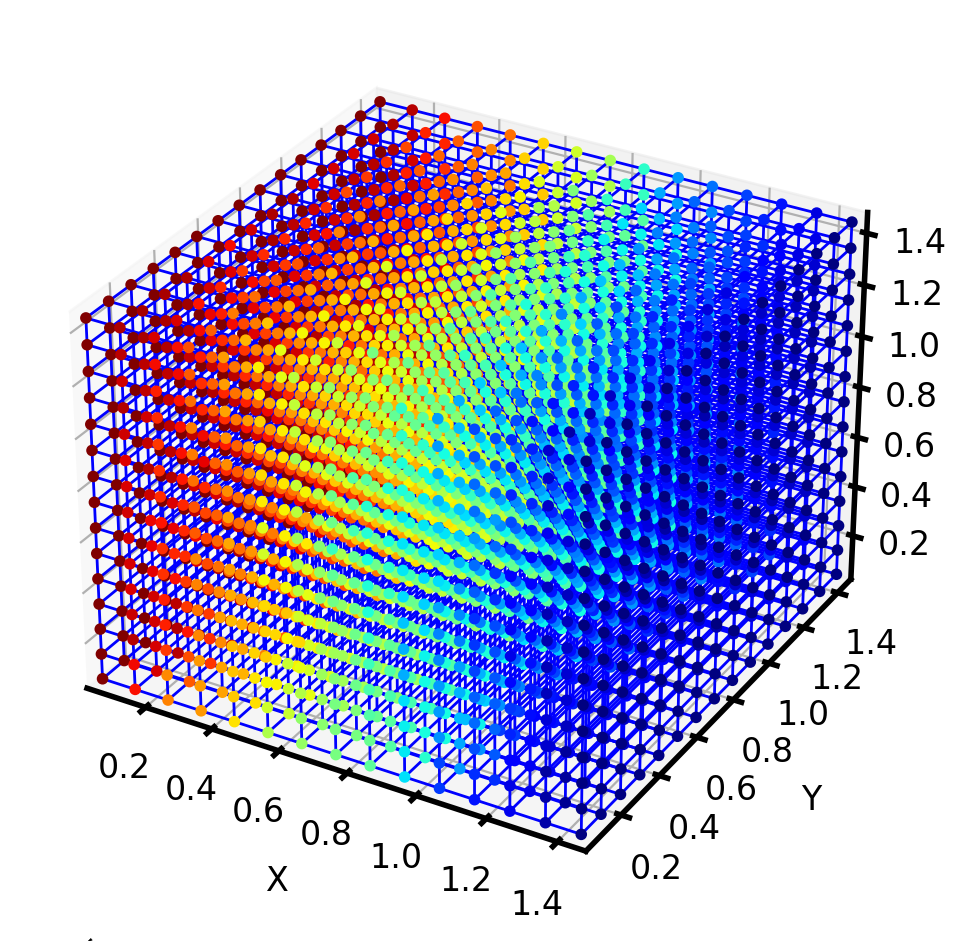

In [5]:
ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax, color_by=phase['pore.pressure'])

## Calculate permeability

Calculate the permeability using Darcy's law:

$$ K_{abs}= \frac{Q}{A} \frac{\mu L} {\Delta P} $$


where $Q$ is the inlet flow rate, $A$ is the inlet area, and $L$ is the distance between inlet and outlet. As pressure difference and viscosity were assumed to be 1, we have a simplified equation.  

In [6]:
# NBVAL_IGNORE_OUTPUT
Q = flow.rate(pores=inlet, mode='group')[0]
A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
# K = Q * L * mu / (A * Delta_P) # mu and Delta_P were assumed to be 1.
K = Q * L / A
print(f'The value of K is: {K/0.98e-12*1000:.2f} mD')

[14:35:56] WARNING  Attempting to estimate inlet area...will be low        ]8;id=986293;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py\_topotools.py]8;;\:]8;id=515451;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py#1042\1042]8;;\

           WARNING  Attempting to estimate domain length...could be low if ]8;id=965070;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py\_topotools.py]8;;\:]8;id=24998;file:///home/amin/Code/OpenPNM/openpnm/topotools/_topotools.py#1086\1086]8;;\
                    boundary pores were not added                                            

The value of K is: 0.07 mD


```{note} **Finding permeability of extracted network**
    
    1) The methods of finding domain area in `topotools` is based on Scipy's `ConvexHull`, where a convexhull that includes the inlet pores will be created to approximate the inlet area. Both `get_domain_area` and `get_domain_length` can be a useful approximation in estimating area and length in extracted networks. In extracted networks without boundary pores where inlet/outlet pores are not necessarily located on an almost flat plane, the estimated value could be low.

    2) In this example we assumed the network has spherical pores and cylindrical throats. Different geometrical shapes for pores and throats are defined in `geometry` collection. Each geometry collection includes pore-scale size factor models that are necessary for finding hydraulic conductance of the conduits and applying transport algorithm, accordingly. These size factor models can alternatively be assigned using `add_model` method to the network and choosing the model from `op.models.geometry.hydraulic_size_factors`. For more information on these pore-scale models see size factor example notebook.
    
```